Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper. 

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
from models.dcgan import dcgan
import torch
import torch.optim
from sklearn.model_selection import train_test_split
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image import TotalVariation
import albumentations as A
from albumentations.pytorch import ToTensorV2
# from utils.inpainting_utils import *
import torch.nn as nn

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# Choose figure

In [2]:


# NET_TYPE = 'UNET' # one of skip_depth4|skip_depth2|UNET|ResNet
NET_TYPE = 'UNET'
dtype = torch.float32


batch_size = 2
num_channels = 3

INPUT = 'meshgrid'
input_depth =  num_channels  # Changed to reflect batch size and channel number
num_iter = 4001
show_every = 900
figsize = 8
reg_noise_std = 0.00
param_noise = True

if NET_TYPE == 'UNET':
    # net = UNet(num_input_channels=input_depth, num_output_channels=3, 
    #             feature_scale=8, more_layers=1, 
    #             concat_x=False, upsample_mode='deconv', 
    #             pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
    # net = UNet(num_input_channels=input_depth, num_output_channels=3, 
    #         feature_scale=2, more_layers=0, 
    #         concat_x=False, upsample_mode='deconv', 
    #         pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
    net = UNet()
    LR = 0.001
    param_noise = False


net = net.type(dtype)

# inputs = get_noisee(batch_size, 3, INPUT, 256, noise_type='u', var=1./10)
# print(inputs.shape)



In [3]:
print(net)


UNet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2),

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.utils.data import random_split
import torch.optim as optim
import random

# class ImageLabelDataset(Dataset):
#     def __init__(self, image_dir, label_dir, image_transform=None, label_transform=None):
#         self.image_dir = image_dir
#         self.label_dir = label_dir
#         self.image_files = os.listdir(image_dir)
#         self.image_transform = image_transform
#         self.label_transform = label_transform

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.image_dir, self.image_files[idx])
#         label_name = os.path.join(self.label_dir, self.image_files[idx])

#         image = Image.open(img_name).convert('RGB')
#         label = Image.open(label_name).convert('RGB')  # Assuming label is grayscale

#         seed = np.random.randint(2147483647)  # make a seed with numpy generator 
        
#         if self.image_transform or self.label_transform:
#             random.seed(seed)  # apply this seed to img transforms
#             torch.manual_seed(seed)
#             image = self.image_transform(image)

#             random.seed(seed)  # apply this seed to label transforms
#             torch.manual_seed(seed)
#             label = self.label_transform(label)

#         return image, label

# image_transform = transforms.Compose([
#     transforms.Resize((480, 640)),
#     # transforms.RandomHorizontalFlip(p=0.15),
#     # transforms.RandomRotation(degrees=(-5, 5)),
#     # # transforms.RandomVerticalFlip(p=0.1),
#     # transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.1, hue=0.1),
#     # transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
#     # transforms.RandomEqualize(p=0.01),
#     # transforms.RandomAutocontrast(p=0.01),
#     transforms.ToTensor(),
# ])

# label_transform = transforms.Compose([
#     transforms.Resize((480, 640)),
#     # transforms.RandomHorizontalFlip(p=0.15),
#     # transforms.RandomRotation(degrees=(-5, 5)),
#     # transforms.RandomVerticalFlip(p=0.1),
#     transforms.ToTensor(),
# ])

# # class TrainTransform:
# #     def __init__(self):
# #         self.transform = A.Compose([
# #             A.Resize(480,480),
# #             # A.RandomRotate90(p=0.2),
# #             A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1),
# #             ToTensorV2()
# #         ])

# #     def __call__(self, image, label):
# #         return self.transform(image=image, label=label)
    
# # train_transform = TrainTransform()

# image_dir = train_path
# label_dir = label_path
# dataset = ImageLabelDataset(image_dir=image_dir, label_dir=label_dir, 
#                             image_transform=image_transform, 
#                             label_transform=label_transform)

# total_size = len(dataset)
# train_size = int(0.9 * total_size)
# val_size = (total_size - train_size) // 2
# test_size = total_size - train_size - val_size

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# s  = sum(np.prod(list(p.size())) for p in net.parameters())
# print ('Number of params: %d' % s)

mse = torch.nn.MSELoss().type(dtype)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [9]:
# for batch_idx, (data, target) in enumerate(train_loader):
#     if batch_idx < 2:    
#         # print(data.shape, target.shape)
#         data, target = data.to(device), target.to(device)
#         idx = np.random.randint(0, len(data))
#         print(data.shape, target.shape)
#         print(data[idx,:,:,:].permute(1,2,0).shape)
#         inp = data[idx,:,:,:].permute(1,2,0).detach().cpu().clone().numpy()
#         # out = output[idx,:,:,:].permute(1,2,0).detach().cpu().clone().numpy()
#         lab = target[idx,:,:,:].permute(1,2,0).detach().cpu().clone().numpy()
#         print(lab.shape, type(lab))
#         for i, (j, k) in enumerate(zip(data, target)):
        
#             plt.figure(figsize=(10, 5))

#             ax1 = plt.subplot(1, 2, 1)
#             # print(i.shape, j.shape, k.shape)
#             plt.imshow(j.permute(1,2,0).detach().cpu().clone().numpy())
#             ax1.set_title('Input')
#             ax1.axis('off')


#             ax3 = plt.subplot(1, 2, 2)
#             plt.imshow(k.permute(1,2,0).detach().cpu().clone().numpy())
#             ax3.set_title('Target')
#             ax3.axis('off') 

#             plt.tight_layout()
#             plt.show()

#     else:
#         break
        

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [21]:
# net.load_state_dict(torch.load('/home/jc-merlab/Venk/deep-image-prior-master/saved models/10_att_augment.pth'))
trained_model_23_nov = '/home/jc-merlab/Pictures/Data/trained_models/inpainting/13Dec_att_generative_was_YCB.pth'
net.load_state_dict(torch.load(trained_model_23_nov))

<All keys matched successfully>

In [ ]:

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# net = net.to(device)
# criterion = nn.MSELoss().type(dtype)  
# # criterion = nn.L1Loss().type(dtype)
# # criterion = StructuralSimilarityIndexMeasure().type(dtype).to(device)
# optimizer = optim.Adam(net.parameters(), lr=0.0001)
# num_epochs = 30

# for epoch in range(num_epochs):  
#     net.train()
#     train_loss = 0

#     for batch_idx, (data, target) in enumerate(train_loader):
#         # print(data.shape, target.shape)
#         data, target = data.to(device), target.to(device)
        
#         # net_input = get_noisee(data.shape[0], input_depth, INPUT, data.shape[2:]).to(device)
        
#         optimizer.zero_grad()
#         output = net(data)
        
#         loss = criterion(output, target)
#         train_loss = train_loss + loss.item()
#         loss.backward()
#         optimizer.step()
            
#     net.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for data, target in val_loader:

#             data, target = data.to(device), target.to(device)
#             # print(data.shape, target.shape)
#             # net_input = get_noisee(data.shape[0], input_depth, INPUT, data.shape[2:]).to(device)
#             output = net(data)
#             # print(output.shape)
#             valloss = criterion(output, target)
#             val_loss = val_loss + valloss.item()
#             idx = np.random.randint(0, len(data))

#         print(data[idx,:,:,:].permute(1,2,0).shape)
#         inp = data[idx,:,:,:].permute(1,2,0).detach().cpu().clone().numpy()
#         out = output[idx,:,:,:].permute(1,2,0).detach().cpu().clone().numpy()
#         lab = target[idx,:,:,:].permute(1,2,0).detach().cpu().clone().numpy()
#         # print(out.shape, type(out), lab.shape, type(lab))

#         plt.figure(figsize=(15, 15))

#         ax1 = plt.subplot(1, 2, 1)
#         plt.imshow(inp)
#         ax1.set_title('Input')
#         ax1.axis('off')

#         ax2 = plt.subplot(1, 2, 2)
#         plt.imshow(out)
#         ax2.set_title('Output')
#         ax2.axis('off')  

#         # ax3 = plt.subplot(1, 3, 3)
#         # plt.imshow(lab)
#         # ax3.set_title('Target')
#         # ax3.axis('off') 

#         plt.tight_layout()
#         plt.show()
            
    
#     val_loss /= len(val_loader)
#     train_loss /= len(train_loader)
#     writer.add_scalar("Loss/train", train_loss, epoch)
#     writer.add_scalar("Loss/val", val_loss, epoch)
#     print(f"Training Loss after Epoch {epoch}: {train_loss}")
#     print(f"Validation Loss after Epoch {epoch}: {val_loss}")

In [ ]:
# torch.save(net.state_dict(), '/home/jc-merlab/Venk/deep-image-prior-master/saved models/22nov_aug.pth')
# torch.save(net.state_dict(), '/home/jc-merlab/Venk/deep-image-prior-master/saved models/24nov_aug.pth')

In [7]:
# net.load_state_dict(torch.load('/home/jc-merlab/Venk/deep-image-prior-master/saved models/22nov_aug.pth'))
# net.load_state_dict(torch.load('/home/jc-merlab/Venk/deep-image-prior-master/saved models/24nov_aug.pth'))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# net = net.to(device)

In [ ]:
# net.eval()
# import cv2
# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(test_loader):
#         # if batch_idx < 2:
#             data, target = data.to(device), target.to(device)
            
#             # net_input = get_noisee(data.shape[0], input_depth, INPUT, data.shape[2:]).to(device)
            
#             output = net(data)
            
#             print(data.shape)
#             idx = np.random.randint(0, len(data))

#             print(data[idx,:,:,:].permute(1,2,0).shape)
#             inp = data[idx,:,:,:].permute(1,2,0).detach().cpu().clone().numpy()
#             out = output[idx,:,:,:].permute(1,2,0).detach().cpu().clone().numpy()
#             lab = target[idx,:,:,:].permute(1,2,0).detach().cpu().clone().numpy()
#             # print(out.shape, type(out), lab.shape, type(lab))
            

#             # cv2.imwrite(f'/home/jc-merlab/Venk/deep-image-prior-master/KP_Test/{7+batch_idx}.jpg',out*255)
#             plt.figure(figsize=(15, 15))

#             ax1 = plt.subplot(1, 2, 1)
#             plt.imshow(inp)
#             ax1.set_title('Input')
#             ax1.axis('off')

#             ax2 = plt.subplot(1, 2, 2)
#             plt.imshow(out)
#             ax2.set_title('Output')
#             ax2.axis('off')  

#             # ax3 = plt.subplot(1, 3, 3)
#             # plt.imshow(lab)
#             # ax3.set_title('Target')
#             # ax3.axis('off') 

#             plt.tight_layout()
#             plt.show()


In [ ]:
# p = '/home/jc-merlab/Venk/panda_raw_with_occ/test_27Oct'

# #021277.rgb.jpg

# imglst = []
# for i, img in enumerate(os.listdir(p)):
#     # if i < 16:
#         if (images.endswith(".jpg")):
#             imglst.append(img)


# imglst_sorted = sorted(imglst)
# print(imglst_sorted, "\n", len(imglst_sorted))

# testset = dataset = ImageLabelDataset(image_dir=p, label_dir=p, image_transform=image_transform,label_transform=label_transform)
# test = DataLoader(testset, batch_size=4, shuffle=False)

In [18]:
# import cv2
# net.eval()
# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(test):
#         data, target = data.to(device), target.to(device)
        
#         # net_input = get_noisee(data.shape[0], input_depth, INPUT, data.shape[2:]).to(device)
        
#         output = net(data)
        
#         print(data.shape)
#         idx = np.random.randint(0, len(data))

#         # print(data[idx,:,:,:].permute(1,2,0).shape)
#         # inp = data[idx,:,:,:].permute(1,2,0).detach().cpu().clone().numpy()
#         # out = output[idx,:,:,:].permute(1,2,0).detach().cpu().clone().numpy()
#         # lab = target[idx,:,:,:].permute(1,2,0).detach().cpu().clone().numpy()
#         # print(out.shape, type(out), lab.shape, type(lab))
#         for h,(i, j, k) in enumerate(zip(output, data, target)):
            
#             plt.figure(figsize=(10, 5))

#             ax1 = plt.subplot(1, 3, 1)
#             # print(i.shape, j.shape, k.shape)
#             plt.imshow(j.permute(1,2,0).detach().cpu().clone().numpy())
#             ax1.set_title('Input')
#             ax1.axis('off')

#             name = "/home/jc-merlab/Venk/deep-image-prior-master/KP_Test/" + f'{batch_idx+h}.jpg'
#             print(name)
#             ax2 = plt.subplot(1, 3, 2)
#             plt.imshow(i.permute(1,2,0).detach().cpu().clone().numpy())
#             # cv2.imwrite(name,(i.permute(1,2,0).detach().cpu().clone().numpy())*255)
#             ax2.set_title('Output')
#             ax2.axis('off')  

#             ax3 = plt.subplot(1, 3, 3)
#             plt.imshow(k.permute(1,2,0).detach().cpu().clone().numpy())
#             ax3.set_title('Target')
#             ax3.axis('off') 

#             plt.tight_layout()
#             plt.show()


In [22]:
import os
import sys
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
# from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
# from torchsummary import summary

from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

# # Get the directory of the current script
# current_script_dir = os.path.dirname(os.path.abspath(__file__))

# # Navigate up to the 'scripts' directory
# scripts_dir = os.path.dirname(current_script_dir)

# # Add 'scripts' directory to sys.path
# sys.path.append(scripts_dir)

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate


t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
f = r-a  # free inside reserved

16908615680
517996544
508453376


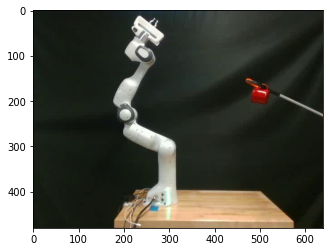

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


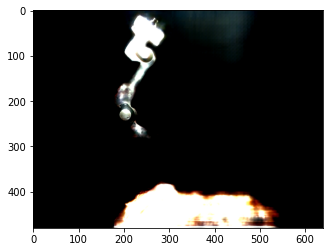

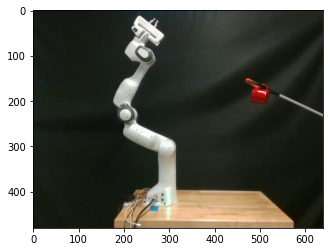

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


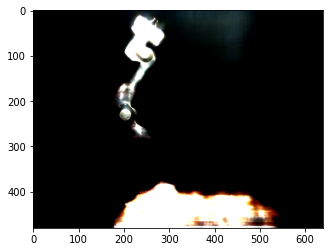

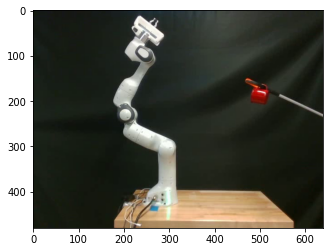

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


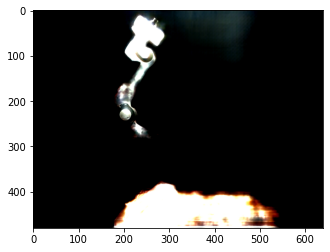

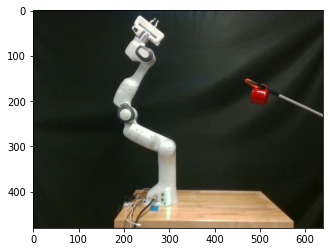

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


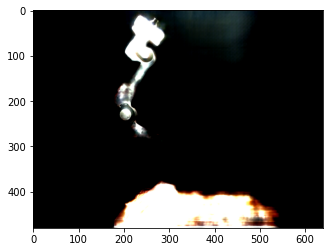

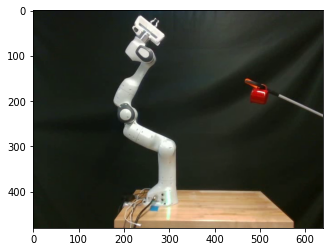

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


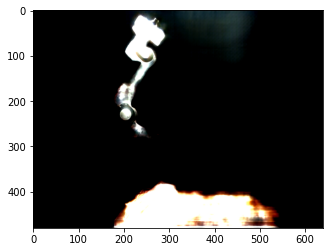

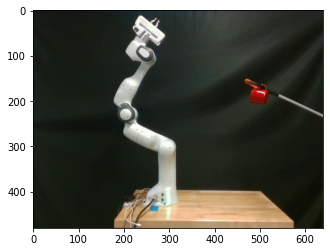

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


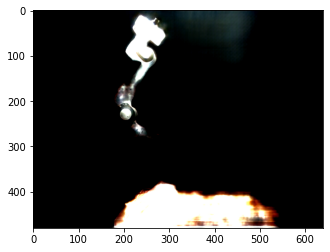

KeyboardInterrupt: 

In [29]:

import cv2
import torch
import matplotlib.pyplot as plt

# Load video
cap = cv2.VideoCapture('/home/jc-merlab/Pictures/panda_data/images_for_occlusion/1/occ_test_1.avi')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# trained_model_23_nov = '/home/jc-merlab/Venk/deep-image-prior-master/saved models/24nov_aug.pth'
# net.load_state_dict(torch.load(trained_model_23_nov))
# Prepare video writer
out = cv2.VideoWriter('/home/jc-merlab/Pictures/panda_data/images_for_occlusion/1/occ_test_1_op.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))
net.eval()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame)
    plt.show()

    # Convert frame to tensor and normalize
    frame_tensor = torch.from_numpy(frame).float()
    frame_tensor = frame_tensor.permute(2, 0, 1) / 255.0  # Normalize and convert HWC to CHW
    frame_tensor = frame_tensor.unsqueeze(0)  # Add batch dimension

    # Move to GPU if available
    if torch.cuda.is_available():
        frame_tensor = frame_tensor.to('cuda')

    # Inference
    inpainted_frame_tensor = net(frame_tensor)

    # Move to CPU and convert to numpy for visualization
    inpainted_frame_tensor = inpainted_frame_tensor.to('cpu').detach()
    inpainted_frame1 = inpainted_frame_tensor.squeeze(0).permute(1, 2, 0).numpy()

    # Assuming the output is in [0, 1], we scale to [0, 255] for visualization
    inpainted_frame = (inpainted_frame1 * 255).astype(np.uint8)

    # Convert RGB to BGR for OpenCV
    # inpainted_frame_bgr = cv2.cvtColor(inpainted_frame, c1.COLOR_RGB2BGR)

    # Display the frame
    plt.imshow(inpainted_frame1)
    plt.show()

    # Write the frame into the file
    # out.write(inpainted_frame_bgr)  # Make sure to write BGR image

# Release everything when done
cap.release()
out.release()

